In this notebook, we rotate the Planck $2018$ mask from Galactic coordinate to Equatorial coordinate and apodize it. 

In [1]:
import healpy as hp
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Define $\ell_{\rm max}$ and `NSIDE` the mask.

In [2]:
NSIDE_OUT = 1024
LMAX_OUT = 3 * NSIDE_OUT - 1

#plotting params
fsize = (7, 7)
fs = 20

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWa

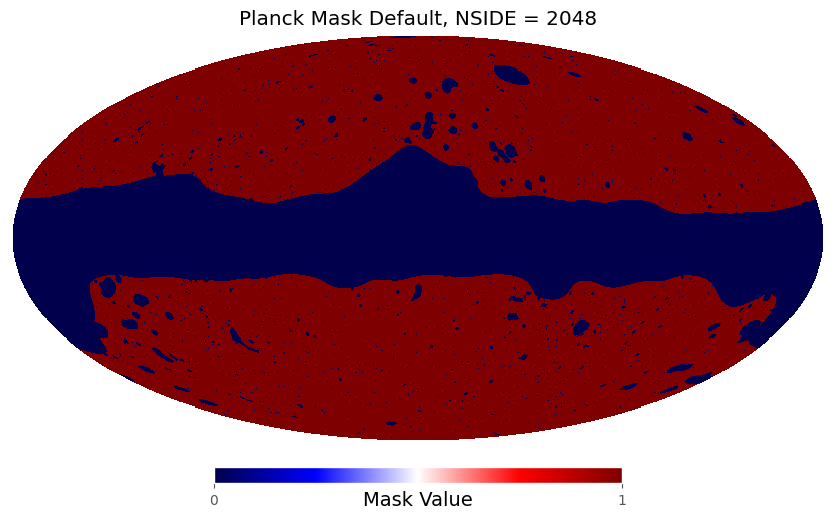

In [3]:
#cmb lensing mask
planck_mask_gal = hp.fitsfunc.read_map("/global/cscratch1/sd/tanveerk/cmb/lensing/mask.fits") 
hp.mollview(planck_mask_gal, title = "Planck Mask Default, NSIDE = 2048", unit = 'Mask Value', cmap = 'seismic', min = 0, max = 1)
plt.show()

In [4]:
# calculate power spectrum of the mask
planck_cl_gal_2048 = hp.anafast(planck_mask_gal, pol = False, lmax = LMAX_OUT)

## Rotate mask from Galactic to Equatorial 

We rotate the mask's $a_{\ell m}$ from Galactic to Equatorial. First we calculate the $a_{\ell m}$s and then rotate it. 

In [ ]:
planck_mask_gal_alms = hp.map2alm(planck_mask_gal, lmax = LMAX_OUT, pol=False) #only keep up to LMAX_OUT values

r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask_eq_alms = r.rotate_alm(planck_mask_gal_alms)

We regenerate the mask in Equatorial basis.

### Change Equatorial basis from NSIDE = 2048 to NSIDE = 1024

In [ ]:
planck_mask_eq_1024 = hp.alm2map(planck_mask_eq_alms, nside=1024, pol = False)
planck_cl_eq_1024 = hp.anafast(planck_mask_eq_1024)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


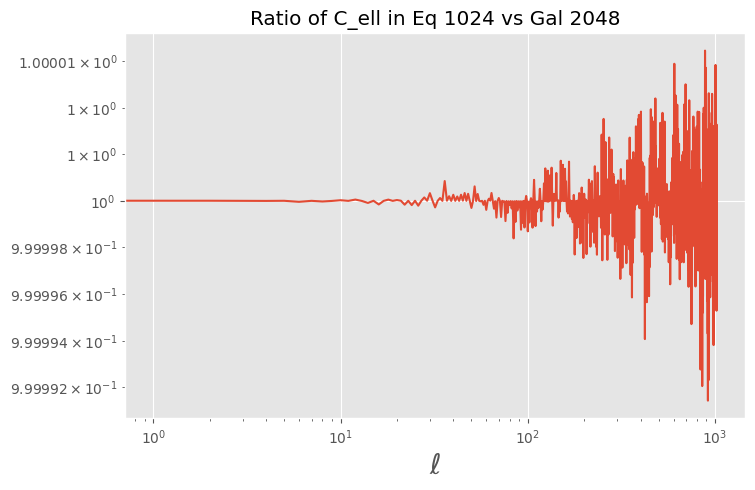

In [ ]:
plt.figure(figsize = (8,5))
plt.loglog(planck_cl_eq_1024[:1024]/planck_cl_gal_2048[:1024])
plt.xlabel(r"$\ell$", fontsize = fs)
#plt.ylabel(r"$C^{\rm mask}_{\ell}$", fontsize = fs)
plt.title("Ratio of C_ell in Eq 1024 vs Gal 2048")
plt.show()

This shows that the realization is good for our analysis. 

In [ ]:
#saving the rotated mask 
np.save("/global/cscratch1/sd/tanveerk/cmb/lensing/mask_rotated_eq_nside_1024.npy", planck_mask_eq_1024)
np.save("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy", planck_mask_eq_1024)

## Apodize map

Once the mask is ready, we multiply it with the signal and then apodize the resultant to get the proper CMB lensing map. Here we demonstrate this with a simple shot noise signal map.

We at first define the apodizing function from [Singh 2021](https://arxiv.org/pdf/2105.04548.pdf) Equation $83$. 

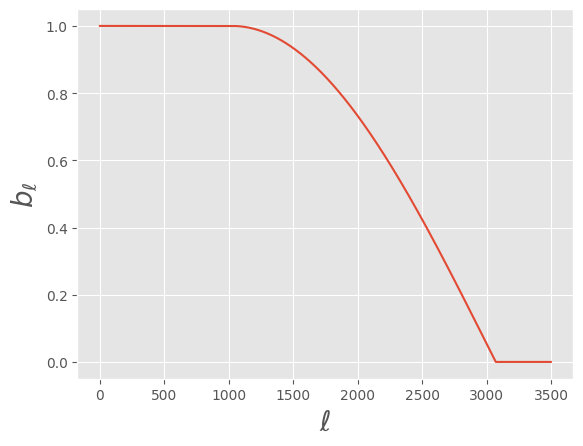

In [11]:
#define and visualize apodization function

def blcos(ell_array, ell_min = 1024, ell_max = 3071):
    blcos_array = np.zeros(ell_array.shape)
    blcos_array[ell_array <= ell_min] = 1.
    blcos_array[(ell_array > ell_min) & (ell_array < ell_max)] = \
    np.cos(np.pi/2 * (ell_array[(ell_array > ell_min) & (ell_array < ell_max)] - ell_min)/(ell_max - ell_min))
    blcos_array[ell_array >= ell_max] = 0.
    return blcos_array

blcos_array = blcos(np.arange(0, 3500))
plt.plot(blcos_array)
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$b_{\ell}$', fontsize = 20)
plt.show()

Now we show a toy example with a simple signal map.

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:396: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

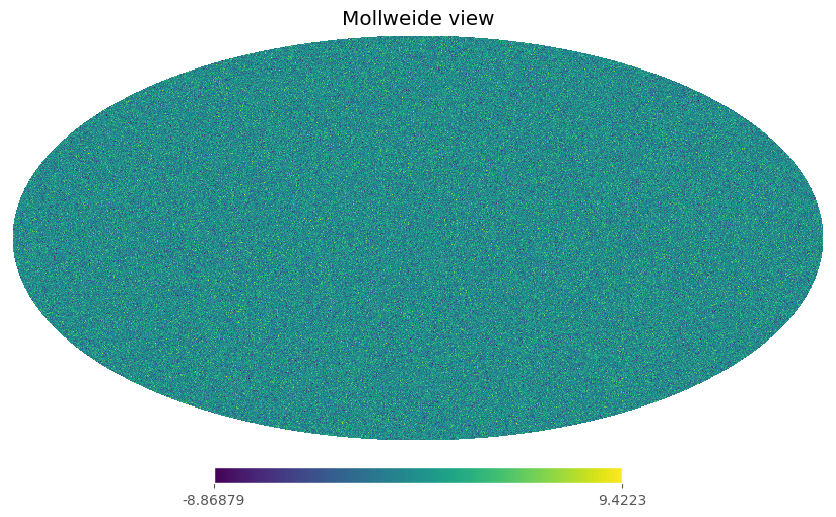

In [38]:
#tmp_map_sig = hp.synfast(cls = 1e-7*np.ones(3071), nside = 1024, pol = False) #represents a signal map
tmp_map_cl = np.genfromtxt('/global/cscratch1/sd/tanveerk/cmb/lensing/MV/nlkk.dat')[:,1] # Planck noise map for testing
tmp_map_sig = hp.synfast(tmp_map_cl, nside=1024)
hp.mollview(tmp_map_sig)
plt.show()

In [39]:
#multiply signal with mask
tmp_map_masked = tmp_map_sig * planck_mask_eq_1024

In [41]:
# apodize the resultant 
tmp_alm_masked = hp.map2alm(tmp_map_masked, pol = False)
tmp_cl_masked = hp.alm2cl(tmp_alm_masked) #calculate power spectrum

tmp_alm_masked_apodized = hp.almxfl(tmp_alm_masked, blcos_array)

In [42]:
# power spectrum of the apodized resultant 
tmp_cl_masked_apodized = hp.alm2cl(tmp_alm_masked_apodized)

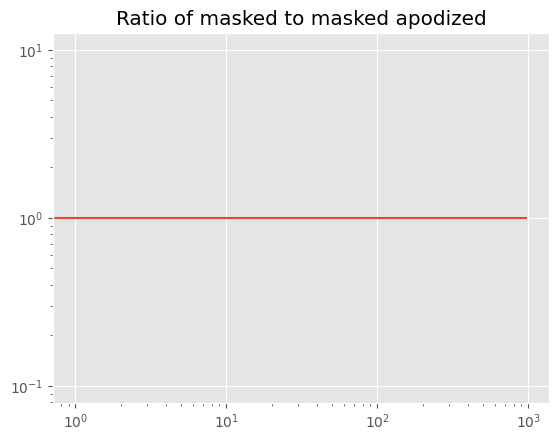

In [43]:
plt.loglog(tmp_cl_masked[50:1024]/tmp_cl_masked_apodized[50:1024])
plt.title("Ratio of masked to masked apodized")
plt.show()

In [44]:
(tmp_cl_masked[50:1024]/tmp_cl_masked_apodized[50:1024]).mean()

1.0

Thus, the apodization does not affect power spectra up to $\ell_{\rm max}$

## Is apodizing the multiplication of signal and mask the same as multiplying signal with apodized mask? 

In [45]:
# apodize the mask
planck_mask_eq_alms_apodized = hp.almxfl(planck_mask_eq_alms, blcos_array)

# generate apodized mask
planck_mask_eq_1024_apodized = hp.alm2map(planck_mask_eq_alms_apodized, nside = 1024)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [46]:
#multiply signal with apodized mask
tmp_map_with_apodized_mask = tmp_map_sig * planck_mask_eq_1024_apodized

#power spectra
tmp_cl_map_with_apo_mask = hp.anafast(tmp_map_with_apodized_mask, pol = False)

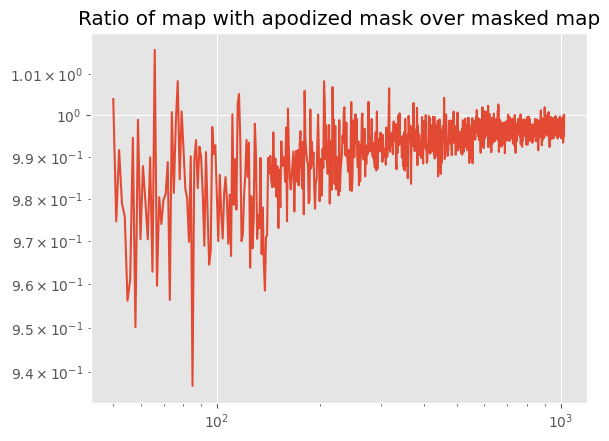

In [51]:
plt.loglog(np.arange(50, 1024), tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked[50:1024])
plt.title("Ratio of map with apodized mask over masked map")
plt.show()

In [48]:
(tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked[50:1024]).mean()

0.9934147910135749

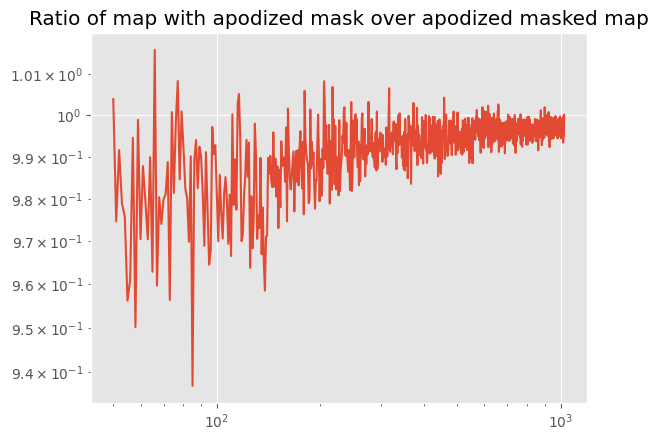

In [52]:
plt.loglog(np.arange(50, 1024), tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked_apodized[50:1024])
plt.title("Ratio of map with apodized mask over apodized masked map")
plt.show()

In [53]:
(tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked_apodized[50:1024]).mean()

0.9934147910135749

These operations are not the same. We ought to multiply signal with mask first and then apodize rather than use an apodized mask. 

In [ ]:
plt.plot(blcos_array)
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$b_{\ell}$', fontsize = 20)
plt.show()

In [47]:
#tmp_alm_masked = hp.map2alm(planck_mask_eq_alms, pol = False)
#tmp_cl_masked = hp.alm2cl(tmp_alm_masked) #calculate power spectrum

tmp_alm_masked_apodized = hp.almxfl(planck_mask_eq_alms, blcos_array)

In [48]:
tmp_cl_masked_apodized = hp.alm2cl(tmp_alm_masked_apodized)

In [50]:
tmp_alm_masked = hp.map2alm(planck_mask_eq_1024, pol = False)
tmp_cl_masked = hp.alm2cl(tmp_alm_masked) #calculate power spectrum

tmp_alm_masked_apodized = hp.almxfl(tmp_alm_masked, blcos_array)

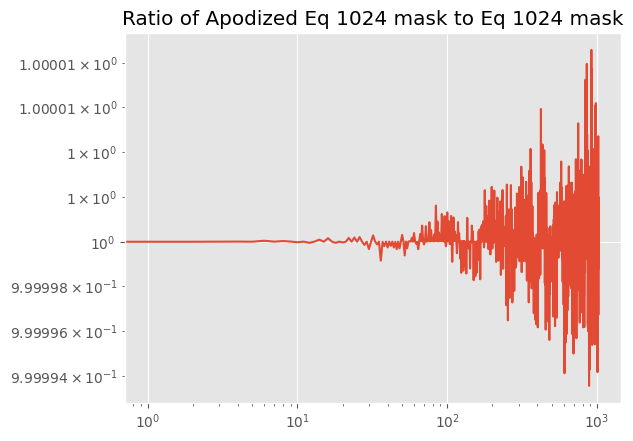

In [52]:
plt.loglog(tmp_cl_masked_apodized[:1024]/planck_cl_eq_1024[:1024])
plt.title("Ratio of Apodized Eq 1024 mask to Eq 1024 mask")
plt.show()

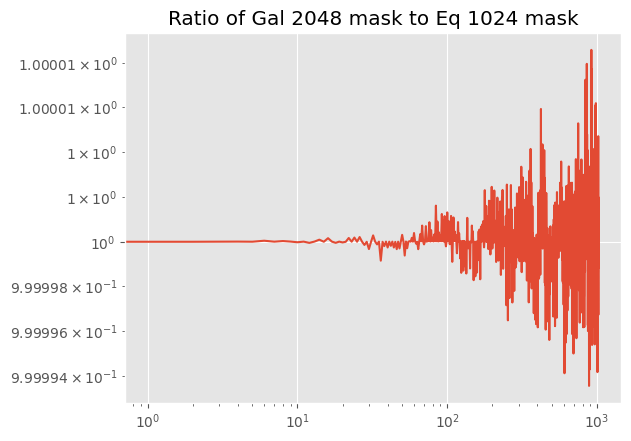

In [53]:
plt.loglog(planck_cl_gal_2048[:1024]/planck_cl_eq_1024[:1024])
plt.title("Ratio of Gal 2048 mask to Eq 1024 mask")
plt.show()

In [56]:
(planck_cl_gal_2048[:1024]/tmp_cl_masked_apodized[:1024]).mean()

0.9999999999999087

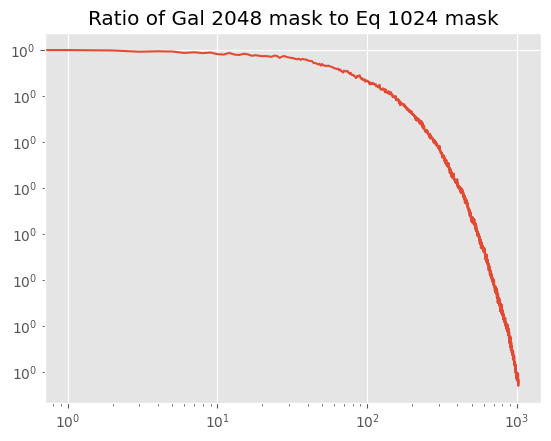

In [54]:
plt.loglog(planck_cl_gal_2048[:1024]/tmp_cl_masked_apodized[:1024])
plt.title("Ratio of Gal 2048 mask to Eq 1024 mask")
plt.show()

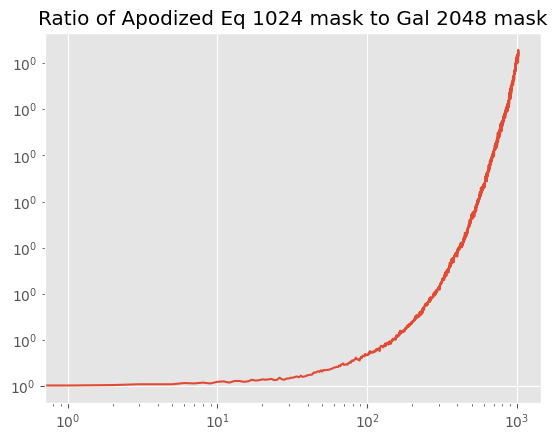

In [51]:
plt.loglog(tmp_cl_masked_apodized[:1024]/planck_cl_gal_2048[:1024])
plt.title("Ratio of Apodized Eq 1024 mask to Gal 2048 mask")
plt.show()

Now we test the degraded map and then checking power spectrum.

In [63]:
#planck_mask_eq_1024 = hp.ud_grade(planck_mask_eq, 1024)
planck_mask_eq_1024_from_alm_map = hp.alm2map(planck_mask_eq_alms, nside = 1024, pol = False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [19]:
#cl_planck_mask_eq_1024_alm = hp.alm2cl(planck_mask_eq_alms, lmax_out=1024)

In [64]:
cl_planck_mask_eq_1024 = hp.anafast(planck_mask_eq_1024, pol = False)
cl_planck_mask_eq_1024_from_alm_map = hp.anafast(planck_mask_eq_1024_from_alm_map, pol = False)

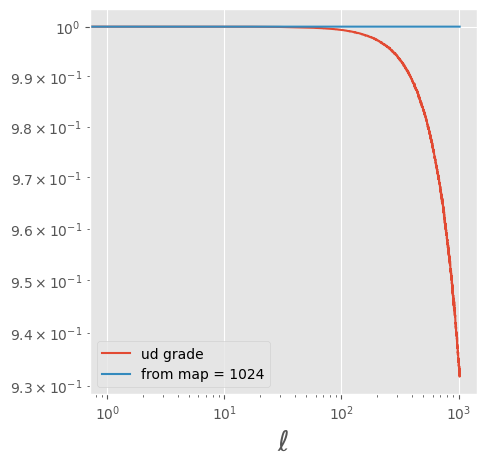

In [65]:
plt.figure(figsize = (5,5))
plt.loglog(np.arange(len(cl_planck_mask_gal))[:1024], cl_planck_mask_eq_1024[:1024]/(cl_planck_mask_gal[:1024]), label = 'ud grade')
plt.loglog(np.arange(1024), cl_planck_mask_eq_1024_from_alm_map[:1024]/cl_planck_mask_gal[:1024], label = 'from map = 1024')
#plt.loglog(np.arange(1024), cl_planck_mask_eq_1024_alm[:1024]/cl_planck_mask_gal[:1024], label = 'alm to cl directly')
plt.legend(loc = 'best')
plt.xlabel(r"$\ell$", fontsize = fs)
#plt.ylabel(r"$C^{\rm mask}_{\ell}$", fontsize = fs)
plt.show()

In [33]:
tmp_1024 = hp.ud_grade(planck_mask_gal, 1024)

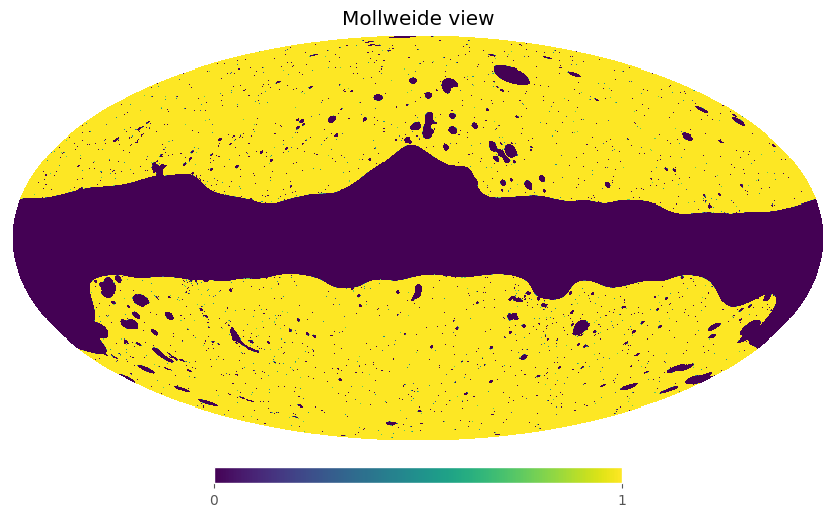

In [34]:
hp.mollview(tmp_1024)
plt.show()

In [41]:
tmp_cl = hp.anafast(tmp_1024)

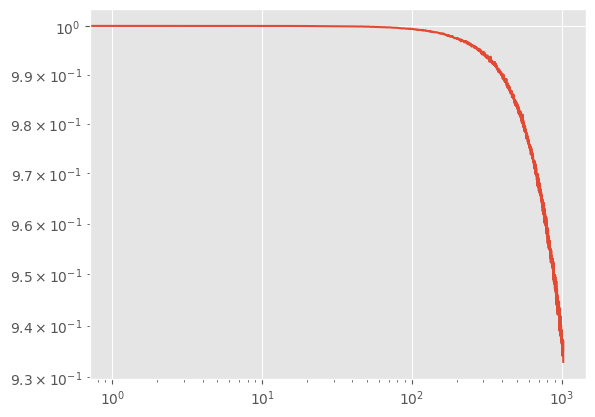

In [43]:
plt.loglog(tmp_cl[:1024]/cl_planck_mask_gal[:1024])
plt.show()

In [36]:
tmp_map = hp.alm2map(planck_mask_gal_alms, nside = 1024, pol = False)
tmp_map_udgrade = hp.ud_grade(planck_mask_gal, 1024)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [37]:
tmp_cl_map = hp.anafast(tmp_map)
tmp_cl_map_udgrade = hp.anafast(tmp_map_udgrade)

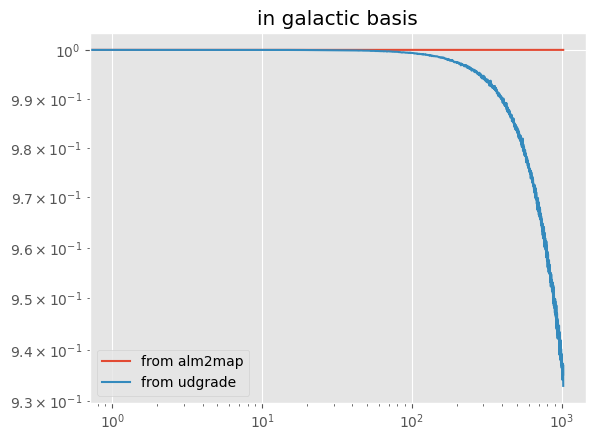

In [39]:
plt.loglog(tmp_cl_map[:1024]/cl_planck_mask_gal[:1024], label = 'from alm2map')
plt.loglog(tmp_cl_map_udgrade[:1024]/cl_planck_mask_gal[:1024], label = 'from udgrade')
plt.legend(loc = 'best')
plt.title("in galactic basis")
plt.show()

Compare cl_eq_2048 with cl_eq_1024

In [44]:
cl_planck_mask_eq[:1024]/cl_planck_mask_eq_1024_from_alm_map[:1024]

array([0.99999997, 1.00000032, 1.00000044, ..., 1.07330389, 1.07322309,
       1.07297596])

In [45]:
tmp_cl_map[:1024]/cl_planck_mask_gal[:1024]

array([1.        , 1.00000003, 0.99999999, ..., 0.99999958, 0.99999813,
       0.9999986 ])

In [46]:
cl_planck_mask_eq[:1024]/cl_planck_mask_gal[:1024]

array([1.        , 1.00000003, 1.        , ..., 0.99999923, 0.99999903,
       0.99999895])

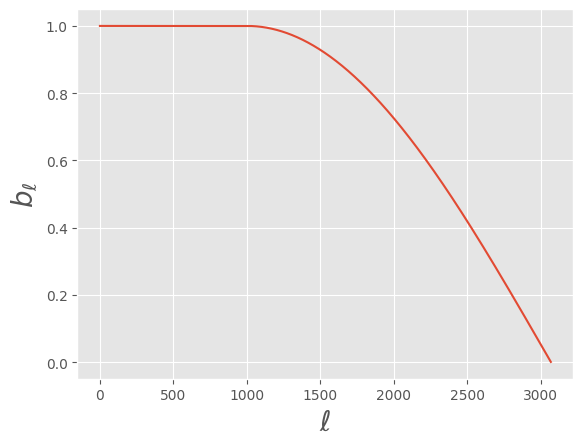

In [21]:
#define and visualize apodization function

def blcos(ell_array, ell_min = 1000, ell_max = LMAX_OUT):
    blcos_array = np.zeros(ell_array.shape)
    blcos_array[ell_array <= ell_min] = 1.
    blcos_array[(ell_array > ell_min) & (ell_array < ell_max)] = \
    np.cos(np.pi/2 * (ell_array[(ell_array > ell_min) & (ell_array < ell_max)] - ell_min)/(ell_max - ell_min))
    
    return blcos_array

blcos_array = blcos(np.arange(0, LMAX_OUT))
plt.plot(blcos_array)
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$b_{\ell}$', fontsize = 20)
plt.show()

In [22]:
#calculate planck a_lms
planck_mask_gal_alms = hp.map2alm(planck_mask_gal, iter = 3, lmax=LMAX_OUT, pol=False)

#multiply a_lms with apodizing function
planck_mask_gal_alms_apodized = hp.almxfl(planck_mask_gal_alms, blcos_array)
planck_mask_gal_apodized = hp.alm2map(planck_mask_gal_alms_apodized, nside = 2048, pol = False) #Planck native resolution

#min-max normalization ##IS THIS ESSENTIAL?
#planck_mask_gal_apodized_norm = (planck_mask_gal_apodized - planck_mask_gal_apodized.min())/\
#(planck_mask_gal_apodized.max() - planck_mask_gal_apodized.min())

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


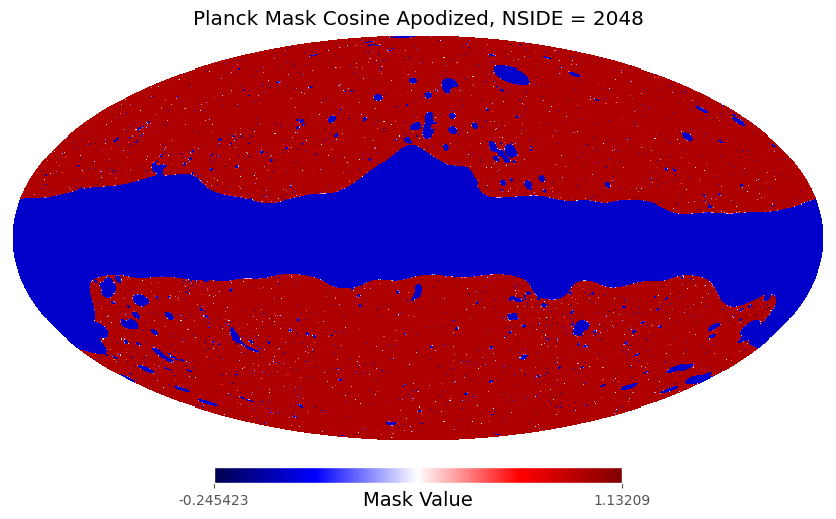

In [23]:
#visualize normalized map
hp.mollview(planck_mask_gal_apodized, title='Planck Mask Cosine Apodized, NSIDE = 2048', 
            unit='Mask Value', cmap = 'seismic')
plt.show()

Difference between apodized map and original map

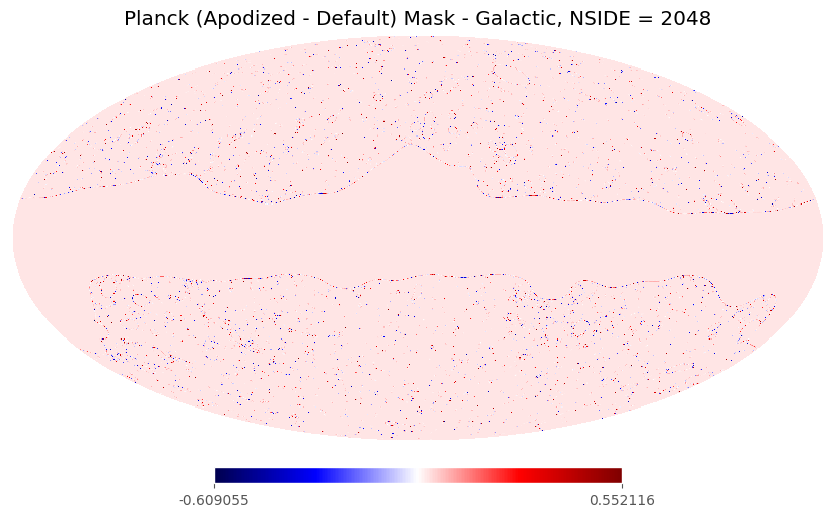

In [24]:
hp.mollview(planck_mask_gal_apodized - planck_mask_gal, cmap = 'seismic', 
            title = "Planck (Apodized - Default) Mask - Galactic, NSIDE = 2048")
plt.show()

Compare power spectra of original mask map and apodized map

In [62]:
cl_planck_mask_gal_apodized = hp.alm2cl(planck_mask_gal_alms_apodized)

In [63]:
cl_planck_mask_gal.shape

(6144,)

In [64]:
tmpstats = cl_planck_mask_gal_apodized[:1024]/cl_planck_mask_gal[:1024]
print(f"mean: {tmpstats.mean()}, std: {tmpstats.std(ddof = 1)}")

mean: 0.9999975582605098, std: 2.139713815447353e-05


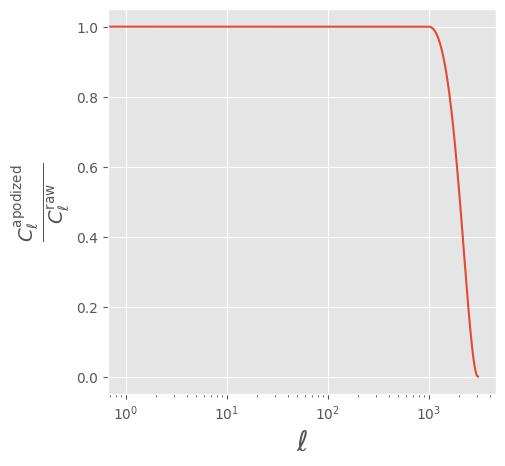

In [65]:
plt.figure(figsize=(5,5))
plt.semilogx(cl_planck_mask_gal_apodized/cl_planck_mask_gal[:LMAX_OUT+1])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm apodized}_{\ell}}{C^{\rm raw}_{\ell}}$", fontsize = 20)
plt.show()

Rotate apodized mask in $a_{\ell m}$ space

In [25]:
#rotate from Eq. Coord. to Gal. Coord to match Planck 
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask_eq_alms_apodized = r.rotate_alm(planck_mask_gal_alms_apodized)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

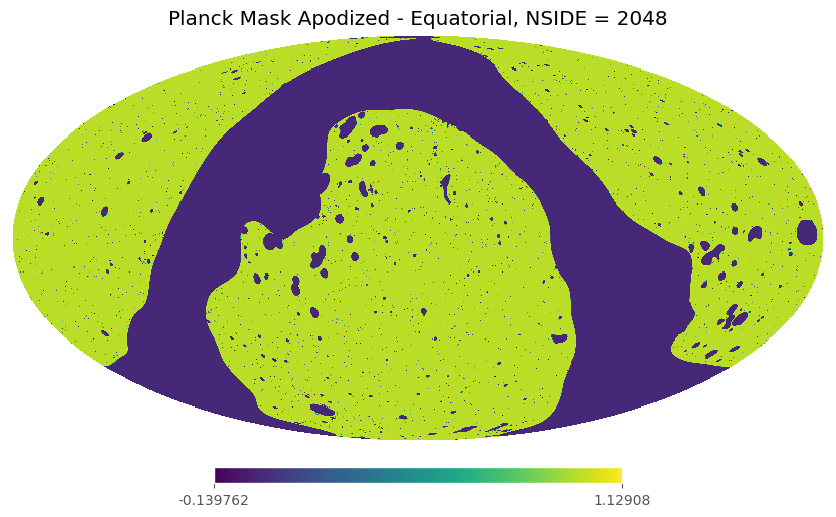

In [26]:
hp.mollview(hp.alm2map(planck_mask_eq_alms_apodized, nside=2048), 
            title = "Planck Mask Apodized - Equatorial, NSIDE = 2048")
plt.show()

In [68]:
cl_planck_mask_eq_apodized = hp.alm2cl(planck_mask_eq_alms_apodized)

<ipython-input-69-540cbce0d2ec>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(cl_planck_mask_eq_apodized/cl_planck_mask_gal_apodized)


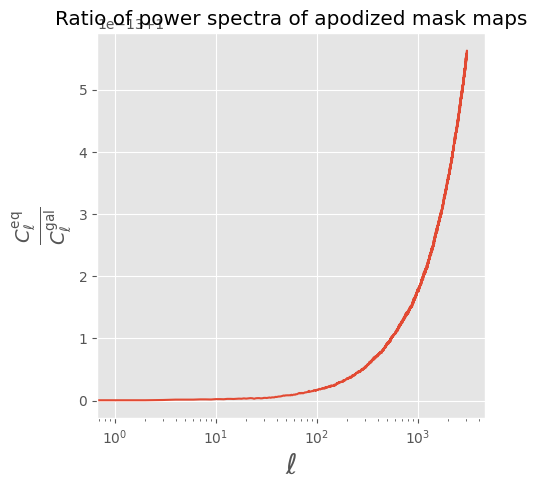

In [69]:
plt.figure(figsize=(5,5))
plt.semilogx(cl_planck_mask_eq_apodized/cl_planck_mask_gal_apodized)
plt.xlabel("$\ell$", fontsize = fs)
plt.ylabel(r"$\frac{C^{\rm eq}_{\ell}}{C^{\rm gal}_{\ell}}$", fontsize = fs)
plt.title("Ratio of power spectra of apodized mask maps")
plt.show()

**Observation:** Rotation is good up to machine precision!

Generate apodized equatorial mask to `NSIDE = 1024`

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

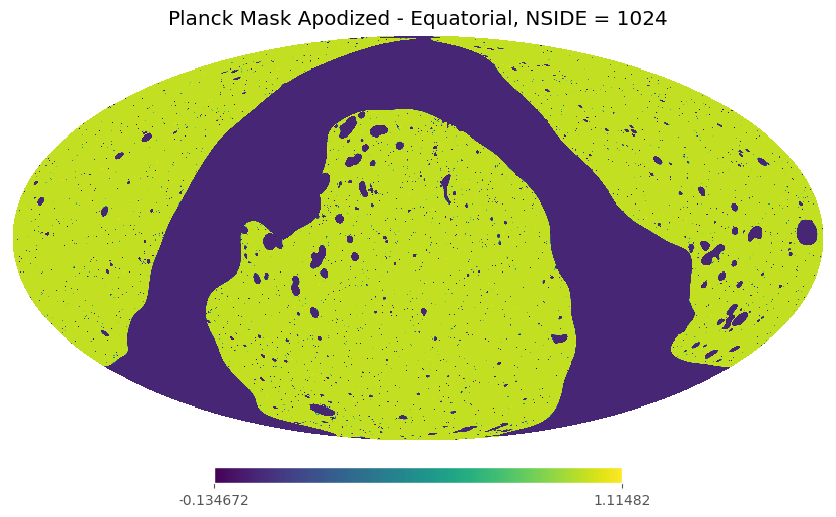

In [70]:
planck_mask_eq_apodized_1024 = hp.alm2map(planck_mask_eq_alms_apodized, nside=NSIDE_OUT, pol = False)
hp.mollview(planck_mask_eq_apodized_1024, title = "Planck Mask Apodized - Equatorial, NSIDE = 1024")
plt.show()

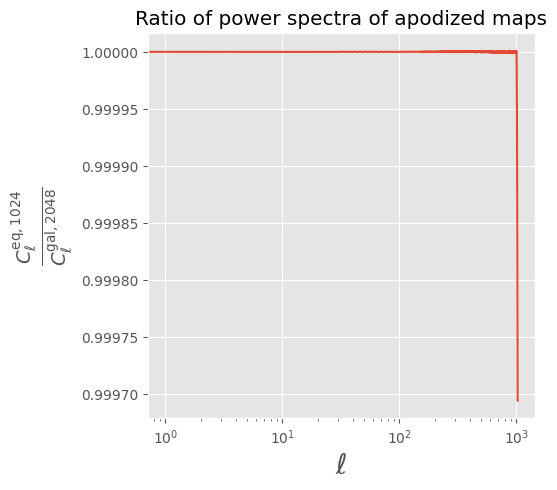

In [77]:
cl_planck_mask_eq_apodized_1024 = hp.alm2cl(planck_mask_eq_alms_apodized, lmax_out=LMAX_OUT)

plt.figure(figsize=(5,5))
#plt.loglog(cl_eq_apodized_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.semilogx(cl_planck_mask_eq_apodized_1024[:1024]/cl_planck_mask_gal[:1024])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")
plt.show()

Shift the apodized Planck mask by a scalar value such that the lowest value is $0$. 

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

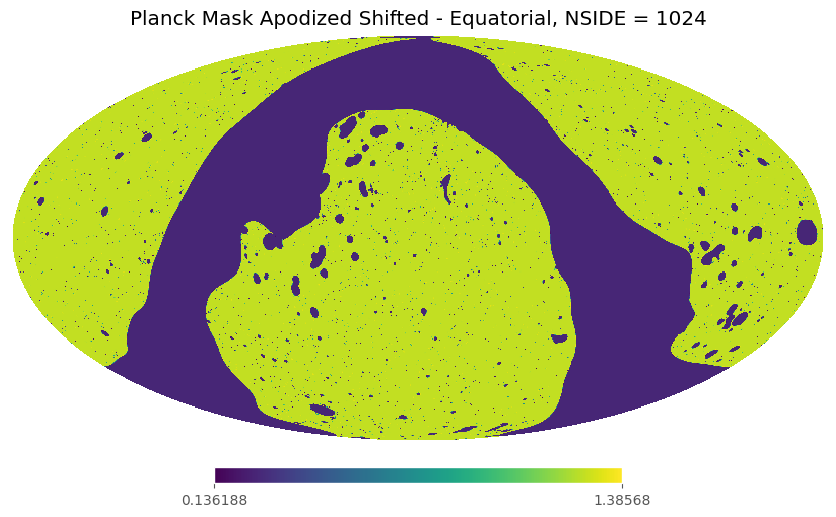

In [39]:
planck_mask_eq_apodized_1024_shifted = planck_mask_eq_apodized_1024 + np.abs(np.min(planck_mask_eq_apodized_1024))
hp.mollview(planck_mask_eq_apodized_1024_shifted, 
            title = "Planck Mask Apodized Shifted - Equatorial, NSIDE = 1024")
plt.show()

<ipython-input-41-9eca52957df5>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx((cl_planck_mask_eq_apodized_1024_shifted/cl_planck_mask_gal_apodized)[10:NSIDE_OUT])


<Figure size 1000x700 with 0 Axes>

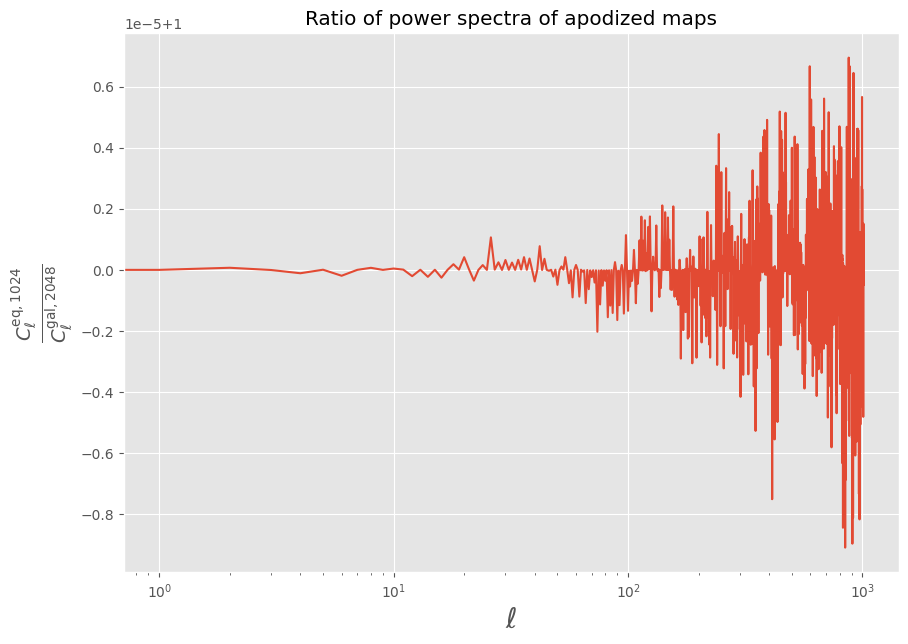

In [41]:
cl_planck_mask_eq_apodized_1024_shifted = hp.anafast(planck_mask_eq_apodized_1024_shifted, pol = False)

plt.figure(figsize=fsize)
#plt.loglog(cl_eq_apodized_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.semilogx((cl_planck_mask_eq_apodized_1024_shifted/cl_planck_mask_gal_apodized)[10:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")
plt.show()

In [42]:
np.save("../dat/planck-lensing-mask-eq-1024.npy", planck_mask_eq_apodized_1024_shifted, allow_pickle=False)

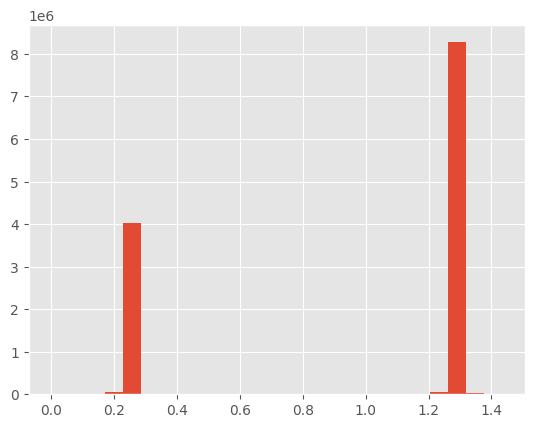

In [46]:
plt.hist(planck_mask_eq_apodized_1024_shifted, bins = 25)
plt.show()

In [48]:
from copy import deepcopy
tmpmask = deepcopy(planck_mask_eq_apodized_1024_shifted)

#set all the values less than 0.5 to 0 and above to 1. 
tmpmask[tmpmask < 0.5] = 0
tmpmask[tmpmask > 0.5] = 1

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

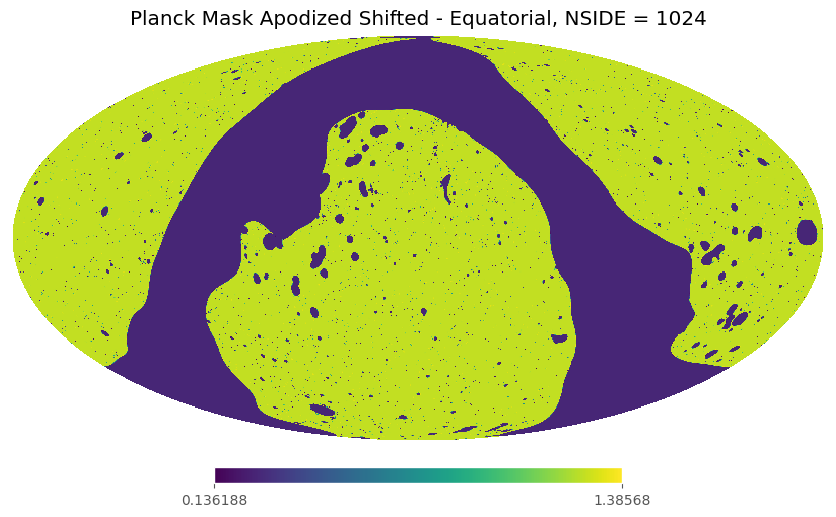

In [49]:
hp.mollview(planck_mask_eq_apodized_1024_shifted, 
            title = "Planck Mask Apodized Shifted - Equatorial, NSIDE = 1024")
plt.show()

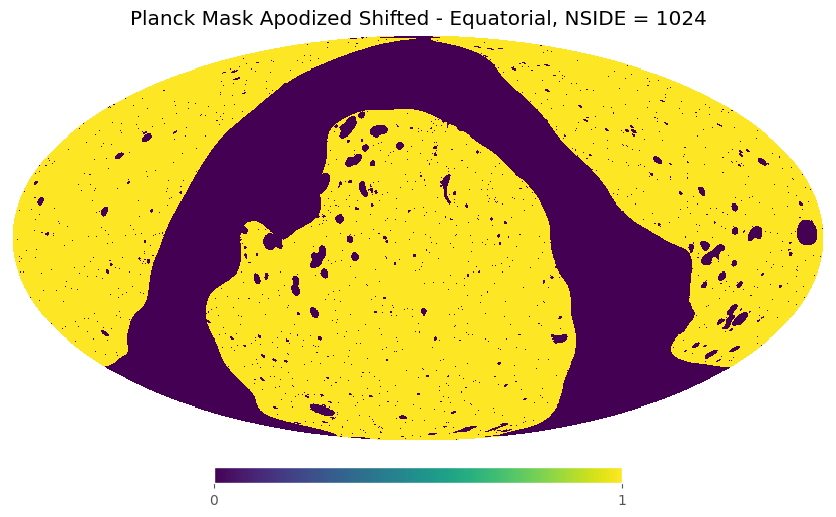

In [50]:
hp.mollview(tmpmask, 
            title = "Planck Mask Apodized Shifted - Equatorial, NSIDE = 1024")
plt.show()

In [51]:
#calculate power spectrum of mask to verify
tmpcl = hp.anafast(tmpmask, pol = False, lmax = 3071, iter = 4)

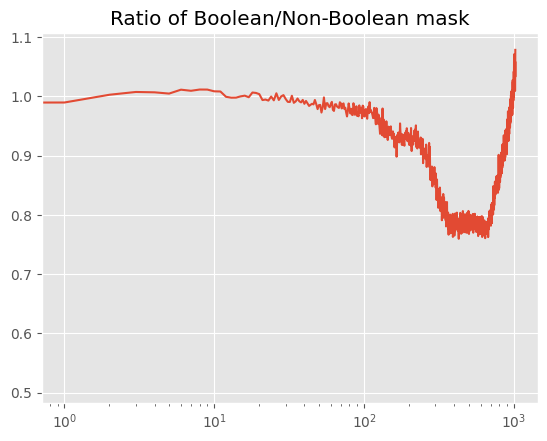

In [58]:
plt.title("Ratio of Boolean/Non-Boolean mask")
plt.semilogx(tmpcl[:1024]/cl_planck_mask_eq_apodized_1024_shifted[:1024])
plt.show()

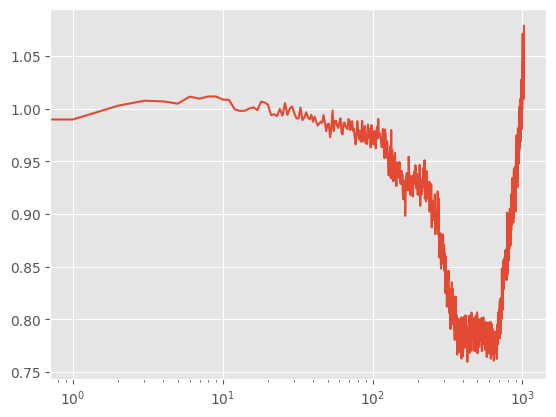

In [59]:
plt.semilogx(tmpcl[:1024]/cl_planck_mask_gal_apodized[:1024])
plt.show()

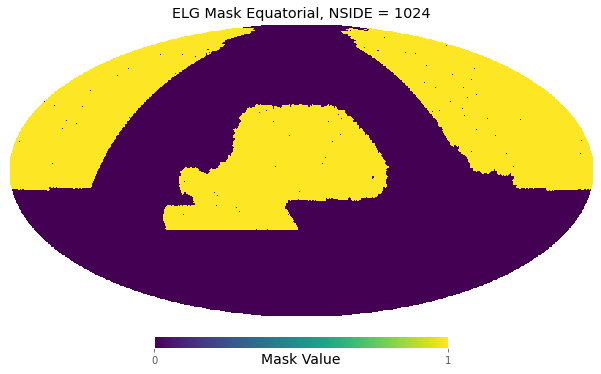

In [17]:
elg_mask_eq = np.load("../../imaging-sys-covariance/dat/elg_ran1024.npy")
elg_mask_eq[elg_mask_eq > 0] = 1
hp.mollview(elg_mask_eq, title = 'ELG Mask Equatorial, NSIDE = 1024', unit='Mask Value')

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


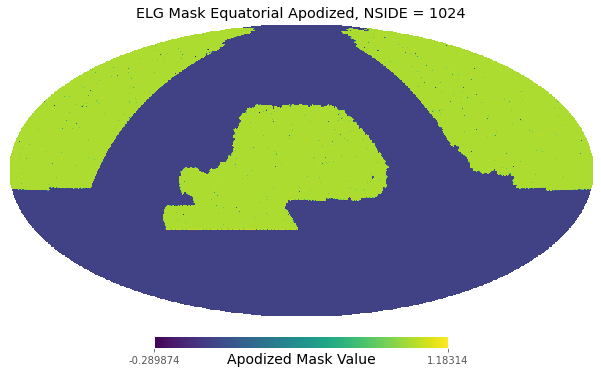

In [18]:
#calculate ELG a_lms
elg_mask_eq_alms = hp.map2alm(elg_mask_eq, lmax=LMAX_OUT, pol=False)

#multiply a_lms with apodizing function
elg_mask_eq_alms_apodized = hp.almxfl(elg_mask_eq_alms, blcos_array)
elg_mask_eq_apodized = hp.alm2map(elg_mask_eq_alms_apodized, nside = NSIDE_OUT)

hp.mollview(elg_mask_eq_apodized, title = 'ELG Mask Equatorial Apodized, NSIDE = 1024', 
            unit = 'Apodized Mask Value')

Visualize both masks together

In [39]:
np.mean(planck_mask_eq_apodized_1024)

0.6706295912641843

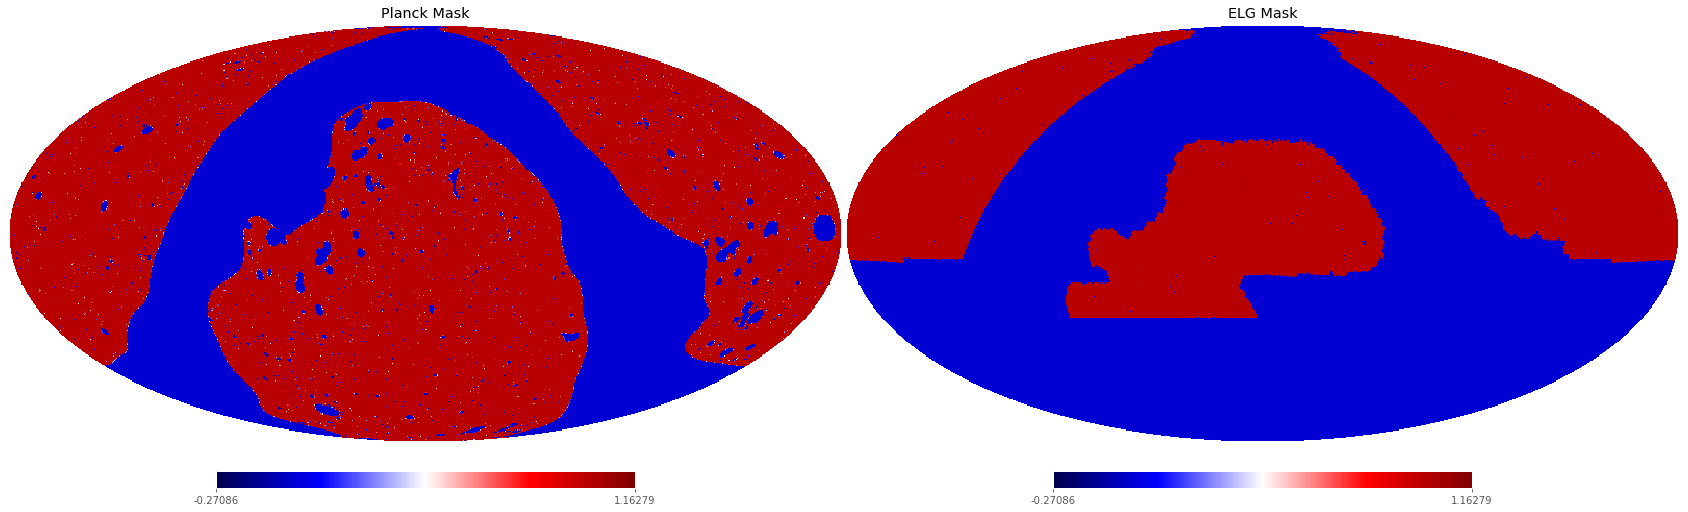

In [18]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(planck_mask_eq_apodized_1024, title = "Planck Mask", hold = True, cmap = 'seismic',
           max = np.maximum(planck_mask_eq_apodized_1024.max(), elg_mask_eq.max()),
           min = np.minimum(planck_mask_eq_apodized_1024.min(), elg_mask_eq.min()))

plt.sca(ax[1])
hp.mollview(elg_mask_eq, title = "ELG Mask", hold = True, cmap = 'seismic',
           max = np.maximum(planck_mask_eq_apodized_1024.max(), elg_mask_eq.max()),
           min = np.minimum(planck_mask_eq_apodized_1024.min(), elg_mask_eq.min()))

Check whether most values are concentrated at $0$ and $1$.

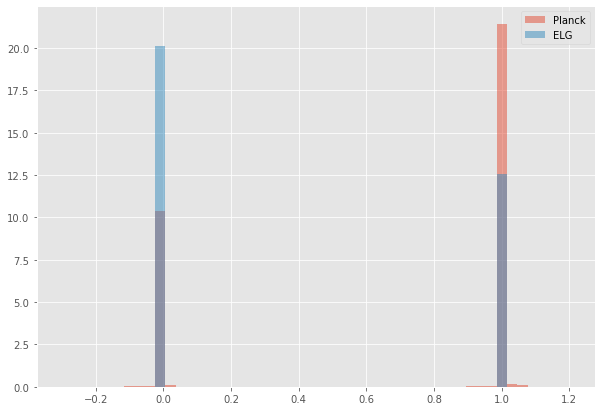

In [19]:
plt.figure(figsize=fsize)
plt.hist(planck_mask_eq_apodized_1024, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Planck', alpha = 0.5);
plt.hist(elg_mask_eq, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'ELG', alpha = 0.5);
plt.legend(loc = 'best')

**Problem:** How to calculate mask in spherical harmonic space? 

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


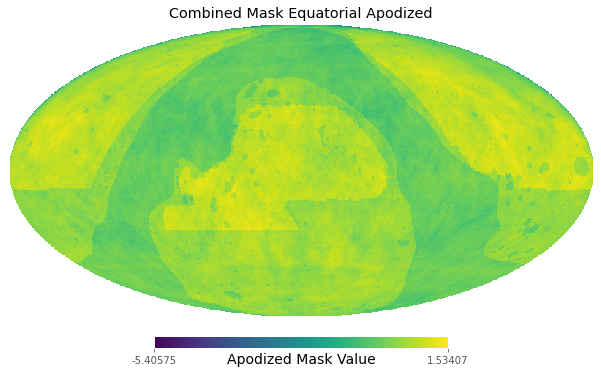

In [48]:
#calculate combined mask in spherical harmonic space and visualize
#comb_mask_eq_alms_apodized = np.minimum(elg_mask_eq_alms_apodized, planck_mask_eq_alms_apodized)
comb_mask_eq_alms_apodized = np.minimum(elg_mask_eq_alms_apodized, planck_mask_eq_alms_apodized)

hp.mollview(hp.alm2map(comb_mask_eq_alms_apodized, nside=NSIDE_OUT), 
            title = 'Combined Mask Equatorial Apodized', unit= 'Apodized Mask Value')

In [75]:
#calculate combined map in harmonic space
tmpcombMap = hp.alm2map(comb_mask_eq_alms_apodized, nside=NSIDE_OUT)

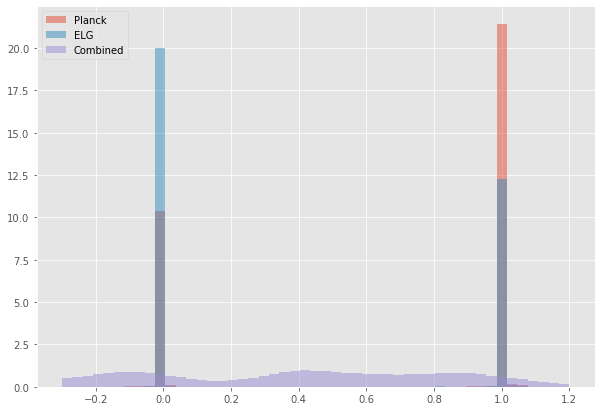

In [76]:
plt.figure(figsize=fsize)
plt.hist(planck_mask_eq_apodized_1024, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Planck', alpha = 0.5);
plt.hist(elg_mask_eq_apodized, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'ELG', alpha = 0.5);
plt.hist(tmpcombMap, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Combined', alpha = 0.5);
plt.legend(loc = 'best')

**Observation:** Combined map looks weird?

In [19]:
#combine mask in real space
combined_mask_eq_1024 = np.minimum(planck_mask_eq_apodized_1024, elg_mask_eq)

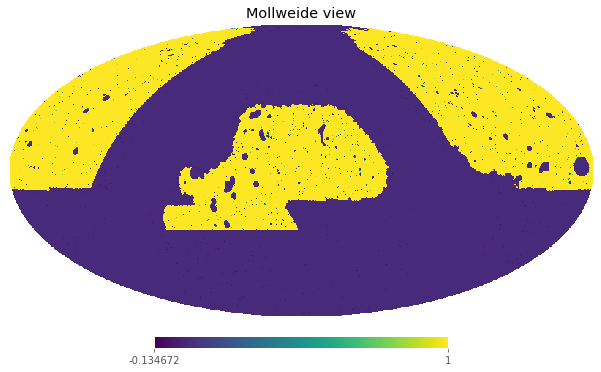

In [20]:
hp.mollview(combined_mask_eq_1024)

In [21]:
cl_combined_mask_eq_1024 = hp.anafast(combined_mask_eq_1024, lmax=LMAX_OUT, pol=False)
cl_elg_mask_eq = hp.anafast(elg_mask_eq, lmax=LMAX_OUT, pol=False)

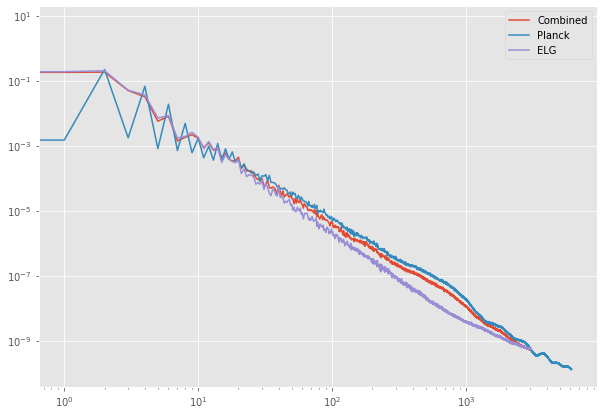

In [23]:
plt.figure(figsize = fsize)
plt.loglog(cl_combined_mask_eq_1024, label = 'Combined')
plt.loglog(cl_planck_mask_gal, label = 'Planck')
plt.loglog(cl_elg_mask_eq, label = 'ELG')
plt.legend(loc = 'best')

In [24]:
np.mean(combined_mask_eq_1024)

0.36772718029816365

In [26]:
tmpmap = deepcopy(combined_mask_eq_1024)
tmpmap[tmpmap >= 0.95] = 1
tmpmap[tmpmap < 0.95] = 0

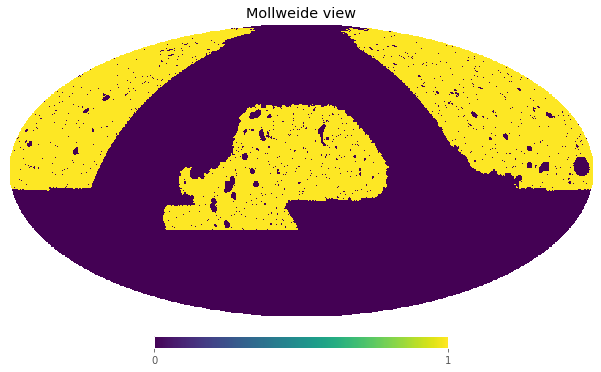

In [27]:
hp.mollview(tmpmap)

In [28]:
np.mean(tmpmap)

0.36560781796773273

In [29]:
cl_tmpmap = hp.anafast(tmpmap, lmax = LMAX_OUT, pol = False)

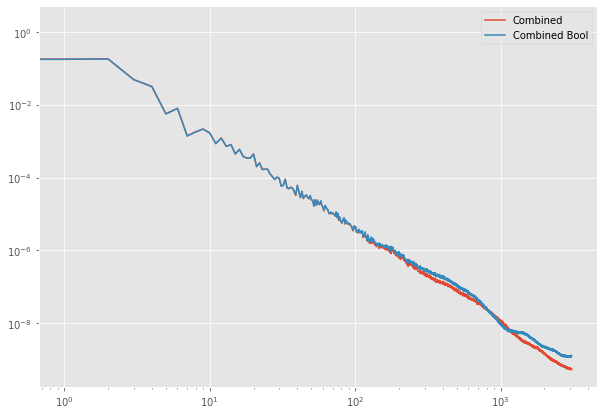

In [31]:
plt.figure(figsize = fsize)
plt.loglog(cl_combined_mask_eq_1024, label = 'Combined')
#plt.loglog(cl_planck_mask_gal, label = 'Planck')
#plt.loglog(cl_elg_mask_eq, label = 'ELG')
plt.loglog(cl_tmpmap, label = 'Combined Bool')
plt.legend(loc = 'best')

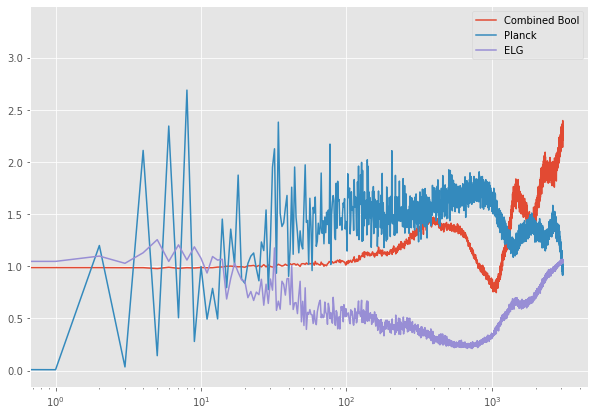

In [37]:
plt.figure(figsize = fsize)
plt.semilogx(cl_tmpmap/cl_combined_mask_eq_1024, label = 'Combined Bool')
plt.semilogx(cl_planck_mask_gal[:LMAX_OUT+1]/cl_combined_mask_eq_1024, label = 'Planck')
plt.semilogx(cl_elg_mask_eq/cl_combined_mask_eq_1024, label = 'ELG')
#plt.loglog(cl_tmpmap, label = 'Combined Bool')
plt.legend(loc = 'best')

In [38]:
tmpmap.sum()/tmpmap.size

0.36560781796773273

In [116]:
ii = 10

In [117]:
elg_mask_eq_alms_apodized[ii]

(-0.06484352708883598+0j)

In [118]:
planck_mask_eq_alms_apodized[ii]

(-0.010308981041548204+0j)

In [119]:
tmpcombMask_alm[ii]

(-0.05153860928088763+0j)

In [120]:
np.minimum(elg_mask_eq_alms_apodized[ii], planck_mask_eq_alms_apodized[ii])

(-0.06484352708883598+0j)

ELGs

In [23]:
elg_mask_eq_apodized[elg_mask_eq_apodized > 0.].size/elg_mask_eq_apodized.size

0.6925705273946127

In [24]:
elg_mask_eq[elg_mask_eq > 0].size/elg_mask_eq.size

0.38390517234802246

Planck

In [25]:
planck_mask_eq_apodized_1024[planck_mask_eq_apodized_1024 > 0].size/planck_mask_eq_apodized_1024.size

0.8362769285837809

In [26]:
planck_mask_gal[planck_mask_gal > 0].size/planck_mask_gal.size

0.670629620552063

Combined

In [27]:
tmpcombMask[tmpcombMask > 0].size/tmpcombMask.size

0.6070423126220703

In [28]:
tmpcombMask[tmpcombMask > 0.5].size/tmpcombMask.size

0.3684261639912923

### Save combined mask

In [175]:
tmptmp = (tmpcombMask - tmpcombMask.min())/(tmpcombMask.max() - tmpcombMask.min())

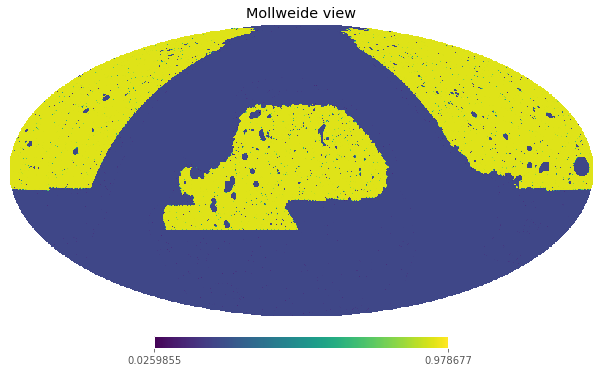

In [176]:
hp.mollview(tmptmp)

In [177]:
tmptmpcl = hp.anafast(tmptmp, pol = False, lmax = LMAX_OUT)
tmpcombMaskcl = hp.anafast(tmpcombMask, pol = False, lmax = LMAX_OUT)

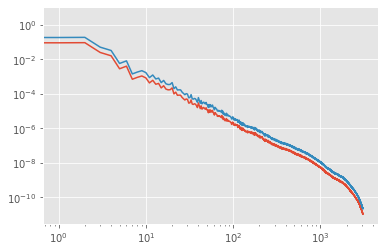

In [178]:
plt.loglog(tmptmpcl)
plt.loglog(tmpcombMaskcl)

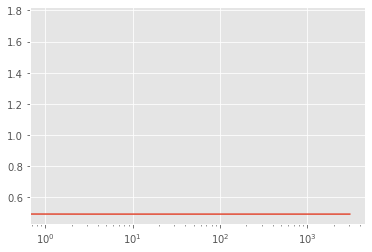

In [179]:
plt.semilogx(tmptmpcl/tmpcombMaskcl)

In [181]:
tmptmpcl/tmpcombMaskcl

array([1.76129877, 0.49330672, 0.49330672, ..., 0.49330672, 0.49335166,
       0.49330672])

In [29]:
np.save("../dat/planck-dr8-commonmask.npy", tmpcombMask, allow_pickle=False)

In [30]:
tmpcombMask.sum()/tmpcombMask.size

0.3674577939994892